[<img src="data/photutils_banner.svg" width=300 alt="">](http://photutils.readthedocs.io/en/stable/index.html)

# Background Estimation with `photutils`
---

##### What is background estimation?
In order to most accurately do photometric analysis of celestial sources in image data, it is important to estimate and subtract the image background. Any astronomical image will have background noise, due to both detector effects and background emission from the night sky. This noise can be modeled as uniform, or as varying with position on the detector. 

The `photutils` package provides tools for estimating 2-dimensional background noise, which can then be subtracted from an image to ensure the most accurate photometry possible.

##### What does this tutorial include?
This tutorial covers the basics of background estimation and subtraction, including the following methods:
- Scalar Background Estimation
- 2-D Background Estimation

The methods demonstrated here are available in narrative form within the `photutils.background` [documentation](http://photutils.readthedocs.io/en/stable/background.html).

<div class="alert alert-block alert-info">**Note:** This notebook focuses on global background estimation. Local background subtraction with <b>annulus apertures</b> is demonstrated in the [aperture photometry notebook](03_photutils_aperture_photometry.ipynb).</div><div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to install or update your [AstroConda](https://astroconda.readthedocs.io) distribution. This notebook may not work properly with older versions of AstroConda.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [5]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
% matplotlib inline

Let's also define some `matplotlib` parameters, to make sure our plots look nice. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [39]:
matplotlib.rc('font', family='serif', weight='light', size=12)
matplotlib.rc('mathtext', bf='serif:normal')
matplotlib.rc('axes', titlesize=20, titlepad=12, labelsize=18)
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('figure', dpi=100)

## Retrieve data

For this example, we will be using Hubble eXtreme Deep Field (XDF) data, collecting using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012 and totalling 1.8 million seconds (500 hours!) of exposure time.

We have place the data for this tutorial in the github repository, for easy access. The data were originally retrieved from the STScI archive: https://archive.stsci.edu/prepds/xdf/

In [125]:
with fits.open('data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits') as hdulist:
    hdulist.info()
    data = hdulist[0].data

Filename: data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5250, 5250)   float32   


Let's look at the data:

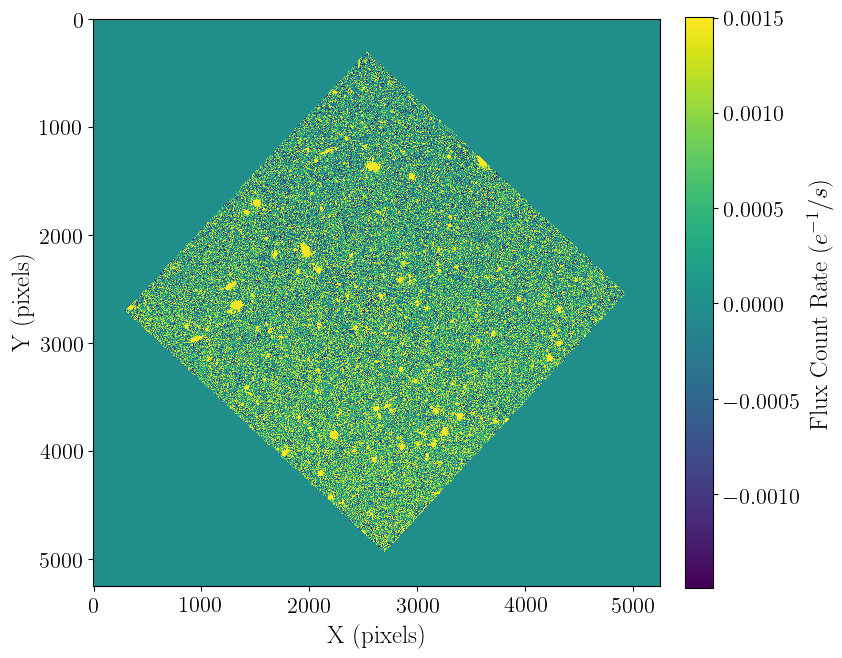

In [126]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# clim = (1e-4, 1e-1)

# data_plot = np.copy(data)
# data_plot[data_plot <= 0] = 1e-10

# Plot the data
norm_image = ImageNormalize(data, interval=ZScaleInterval())
fitsplot = ax1.imshow(data, norm=norm_image)#, clim=clim)
# fitsplot = ax1.imshow(data_plot, clim=clim, norm=LogNorm())

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

plt.show()

## Mask data

You probably noticed that a large portion of the data is equal to zero. The data we are using is a reduced mosaic that combines many different exposures, and that has been rotated such that not all of the array holds data. 

We want to **mask** out the non-data, so all of those pixels that have a value of zero don't interfere with our statistics and analyses of the data.

In [127]:
mask = data == 0

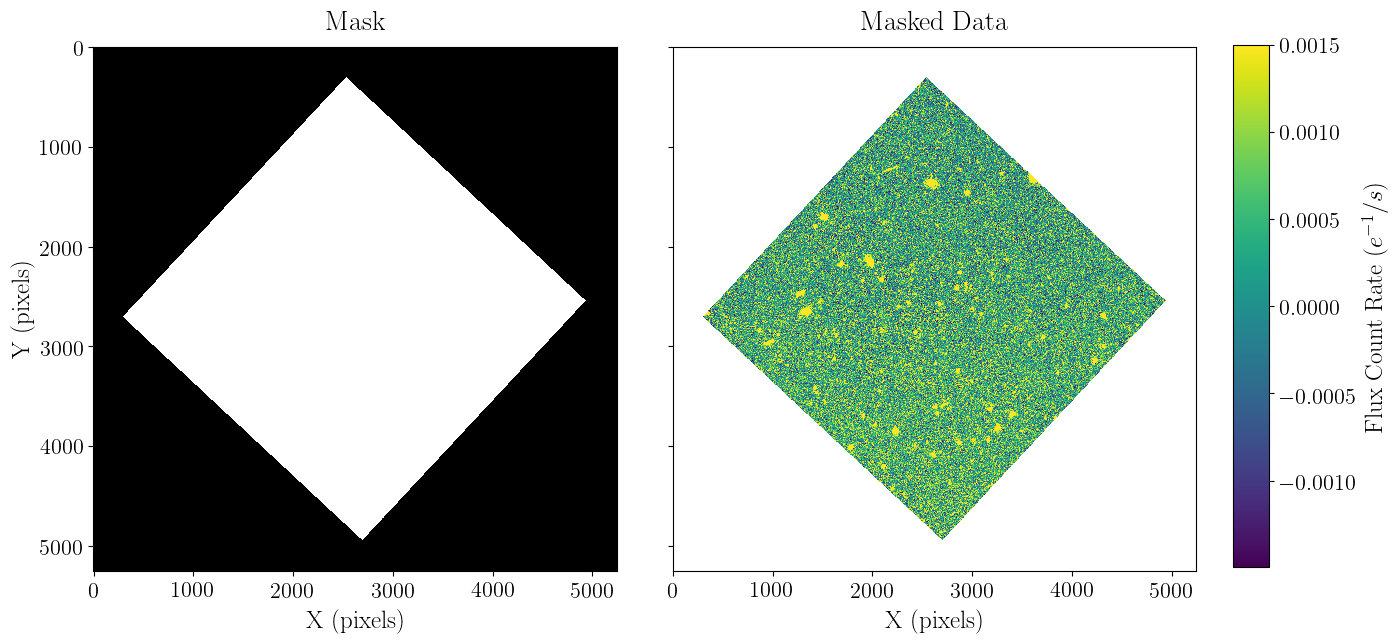

In [142]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# clim = (1e-4, 1e-1)

# Plot the mask
ax1.imshow(mask, cmap='Greys')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Mask')

# Plot the masked data
norm_image = ImageNormalize(data, interval=ZScaleInterval())
fitsplot = ax2.imshow(np.ma.masked_where(mask, data), norm=norm_image)
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)')
ax2.set_xlabel('X (pixels)')
ax2.set_title('Masked Data')

plt.show()

## Perform scalar background estimation

Now that the data are properly masked, we can calculate some basic statistical values to do a basic scalar estimation of the image background.

Here we will calculate the mean, median, and mode using sigma clipping. With sigma clipping, the data is iteratively clipped to exclude data points outside of a certain sigma (standard deviation), thus removing some of the noise from the data before determining statistical values.

In [129]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0, iters=5, mask=mask)

What difference does this sigma clipping make?

In [130]:
print('''
       | Sigma Clipping | No Sigma Clipping
--------------------------------------------
Mean   | {:<14.6f} | {:.6f}
Median | {:<14.6f} | {:.6f}
StdDev | {:<14.6f} | {:.6f}
'''.format(mean, np.average(data[~mask]), median, np.median(data[~mask]), std, np.std(data[~mask])))


       | Sigma Clipping | No Sigma Clipping
--------------------------------------------
Mean   | 0.000363       | 0.000581
Median | 0.000354       | 0.000373
StdDev | 0.000736       | 0.027934



And how important is masking, anyway?

In [131]:
stats_nomask = sigma_clipped_stats(data, sigma=3.0, iters=5)
print('''
       |  Masked  | Not Masked
--------------------------------------------
Mean   | {:<8.6f} | {:.6f}
Median | {:<8.6f} | {:.6f}
StdDev | {:<8.6f} | {:.6f}
'''.format(mean, stats_nomask[0], median, stats_nomask[1], std, stats_nomask[2]))


       |  Masked  | Not Masked
--------------------------------------------
Mean   | 0.000363 | 0.000059
Median | 0.000354 | 0.000000
StdDev | 0.000736 | 0.000309



Let's visualize these differences:

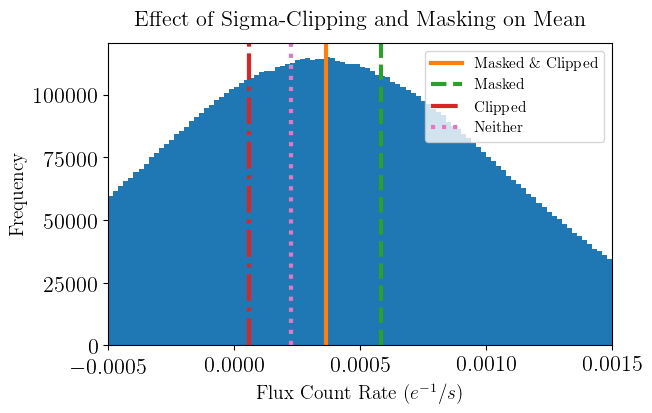

In [137]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4))

# Plot histogram of the data
flux_range = (-.5e-3, 1.5e-3)
ax1.hist(data[~mask], bins=100, range=flux_range)

# Plot lines for each kind of mean
ax1.axvline(mean, label='Masked \& Clipped', c='C1', lw=3)
ax1.axvline(np.average(data[~mask]), label='Masked', c='C2', ls='--', lw=3)
ax1.axvline(no_mask[0], label='Clipped', c='C3', ls='-.', lw=3)
ax1.axvline(np.average(data), label='Neither', c='C6', ls=':', lw=3)

# ax1.set_xscale('log')
# ax1.set_yscale('log')

ax1.set_xlim(flux_range)

ax1.set_xlabel(r'Flux Count Rate ($e^{-1}/s$)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax1.set_title('Effect of Sigma-Clipping and Masking on Mean', fontsize=16)
ax1.legend(fontsize=11)

plt.show()

Just from simply looking at the distribution of the data, it is pretty easy to see how sigma-clipping and masking improve the calculation of the mean.

Okay, enough looking at numbers, let's actually remove the background from the data.

<div class="alert alert-block alert-danger">Should background subtraction be with the mean, or the median?</div>

In [138]:
data_scalarsubtraction = data - mean

And we can calculate the signal-to-noise ratio, $\mu/\sigma$, to quantitatively compare the data before and after.

In [162]:
signal_old = np.average(data * [data > mean])
noise_old = np.std(data * [data < mean])
snr_old = signal_old/noise_old

stats_scalarbkgd = sigma_clipped_stats(data_scalarsubtraction, sigma=3.0, iters=5, mask=mask)
signal_new = np.average(data_scalarsubtraction * [data_scalarsubtraction > stats_scalarbkgd[0]])
noise_new = np.std(data_scalarsubtraction * [data_scalarsubtraction < stats_scalarbkgd[2]])
snr_new = signal_new/noise_new

In [160]:
stats_scalarbkgd

(-2.3733042771503102e-10, -8.7845546659082174e-06, 0.00073596995824502635)

In [161]:
np.average(data_scalarsubtraction)/np.std(data_scalarsubtraction)

-0.0077671446

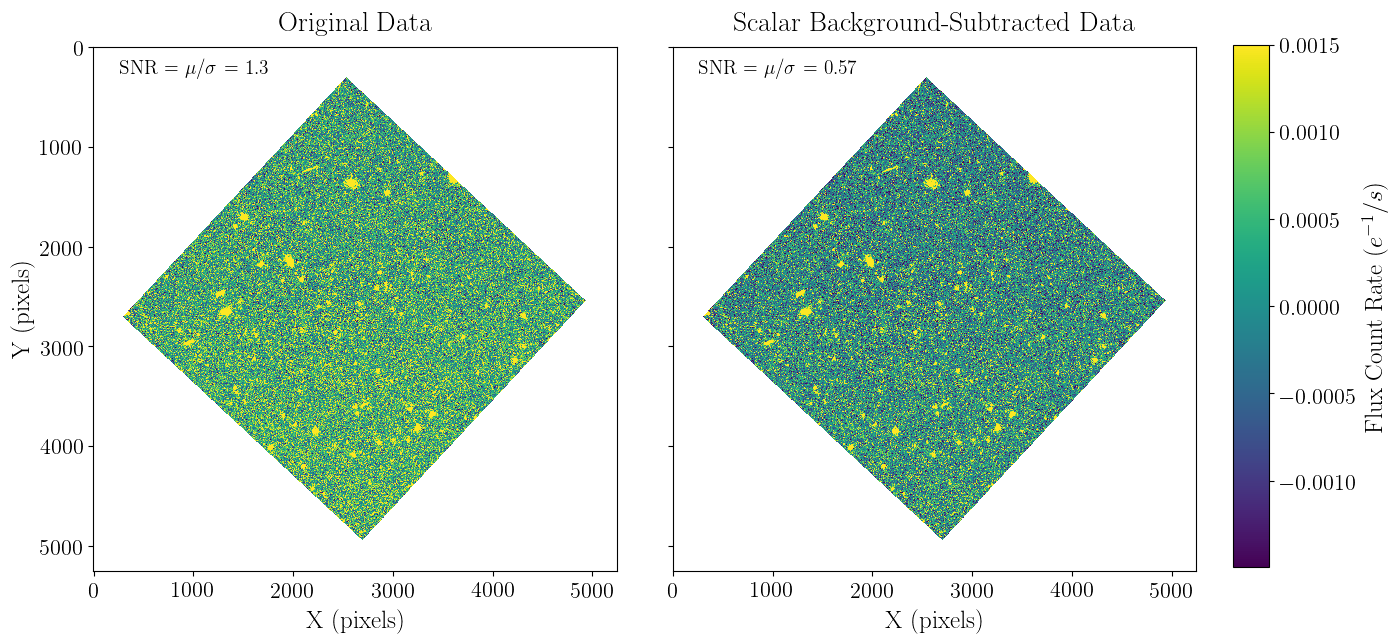

In [163]:
# Set up the figure with subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plt.tight_layout()

# clim = (1e-4, 1e-1)

# Plot the original data
norm_image = ImageNormalize(data, interval=ZScaleInterval())
fitsplot = ax1.imshow(np.ma.masked_where(mask, data), norm=norm_image)
ax1.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_old), transform=ax1.transAxes, fontsize=14)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Original Data')

# Plot the subtracted data
fitsplot = ax2.imshow(np.ma.masked_where(mask, data_scalarsubtraction), norm=norm_image)
ax2.text(0.05, 0.95, 'SNR = $\mu/\sigma$ = {:.2}'.format(snr_new), transform=ax2.transAxes, fontsize=14)
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = fig.colorbar(fitsplot, cbar_ax)
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)')
ax2.set_xlabel('X (pixels)')
ax2.set_title('Scalar Background-Subtracted Data')

plt.show()

## Perform 2-D background estimation

That looks much better! However

In [ ]:
from photutils.background import Background2D, MedianBackground

In [15]:
sigma_clip = SigmaClip(sigma=3., iters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(v_data, 400, filter_size=(10, 10), mask=mask,
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkg.background_median)
print(bkg.background_rms_median)

1.84211013965e-05
0.000589695103296


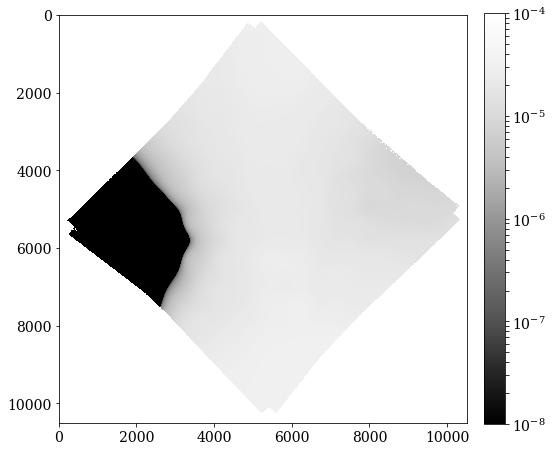

In [35]:
bkgd = np.copy(bkg.background)
bkgd[bkgd <= 0] = 1e-10

fig, ax = plt.subplots(1, 1, figsize=(8,8))
bkgd_plot = ax.imshow(bkgd * ~mask, cmap='Greys_r', norm=LogNorm(), clim=(1e-8, 1e-4))
fig.colorbar(bkgd_plot, fraction=0.046, pad=0.04)
plt.show()

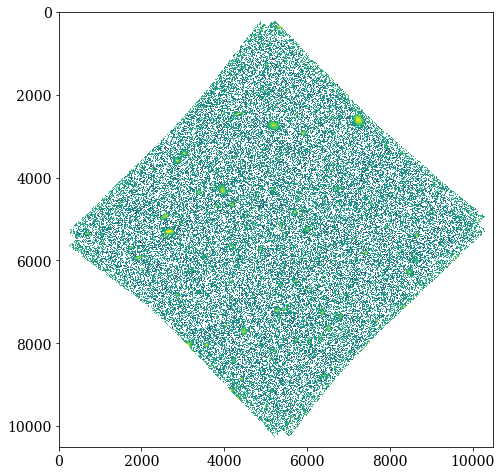

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow((v_data - bkg.background) * ~mask, norm=LogNorm(), clim=(1e-6, 1e-1))
plt.show()

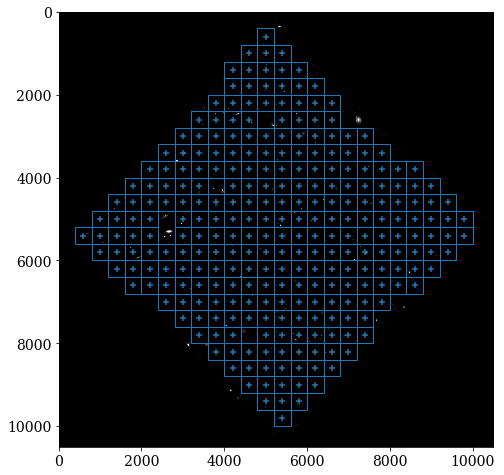

In [25]:
# plot the meshes
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.imshow(v_data_plot * ~mask, cmap='Greys_r', clim=(1e-3, 1e-1))
bkg.plot_meshes(outlines=True, color='#1f77b4')
plt.show()

## Exercises
---

##### To continue with this `photutils` tutorial, go on to the [source detection notebook](02_photutils_source_detection.ipynb).

---
<i>May 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>